# ISLP - Chapter 12 - Exercise 13
### Author: pzuehlke

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial import distance
from scipy import stats

__13 (a):__ Let's read the data in and verify that there are indeed $ 40 $ samples with measurements on $ 1\,000 $ genes:

In [2]:
gene_data = pd.read_csv("Ch12Ex13.csv", header=None)
gene_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 40 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1000 non-null   float64
 1   1       1000 non-null   float64
 2   2       1000 non-null   float64
 3   3       1000 non-null   float64
 4   4       1000 non-null   float64
 5   5       1000 non-null   float64
 6   6       1000 non-null   float64
 7   7       1000 non-null   float64
 8   8       1000 non-null   float64
 9   9       1000 non-null   float64
 10  10      1000 non-null   float64
 11  11      1000 non-null   float64
 12  12      1000 non-null   float64
 13  13      1000 non-null   float64
 14  14      1000 non-null   float64
 15  15      1000 non-null   float64
 16  16      1000 non-null   float64
 17  17      1000 non-null   float64
 18  18      1000 non-null   float64
 19  19      1000 non-null   float64
 20  20      1000 non-null   float64
 21  21      1000 non-null   float64
 22  2

Notice that in this dataset the observations are the _columns_, so let's transpose it to the more usual order:

In [3]:
print(gene_data.shape)
sample_data = gene_data.T
print(sample_data.shape)

(1000, 40)
(40, 1000)


__13 (b):__ We begin by computing the correlation distances between the samples:

In [4]:
distances = distance.pdist(sample_data, metric="correlation")
# Let's check that it has the correct length (40 choose 2):
print(distances.shape)
print(40 * 39 // 2)

(780,)
780


Now we create a large figure and for each of the four linkage methods described in the chapter,
then plot the corresponding dendrogram:

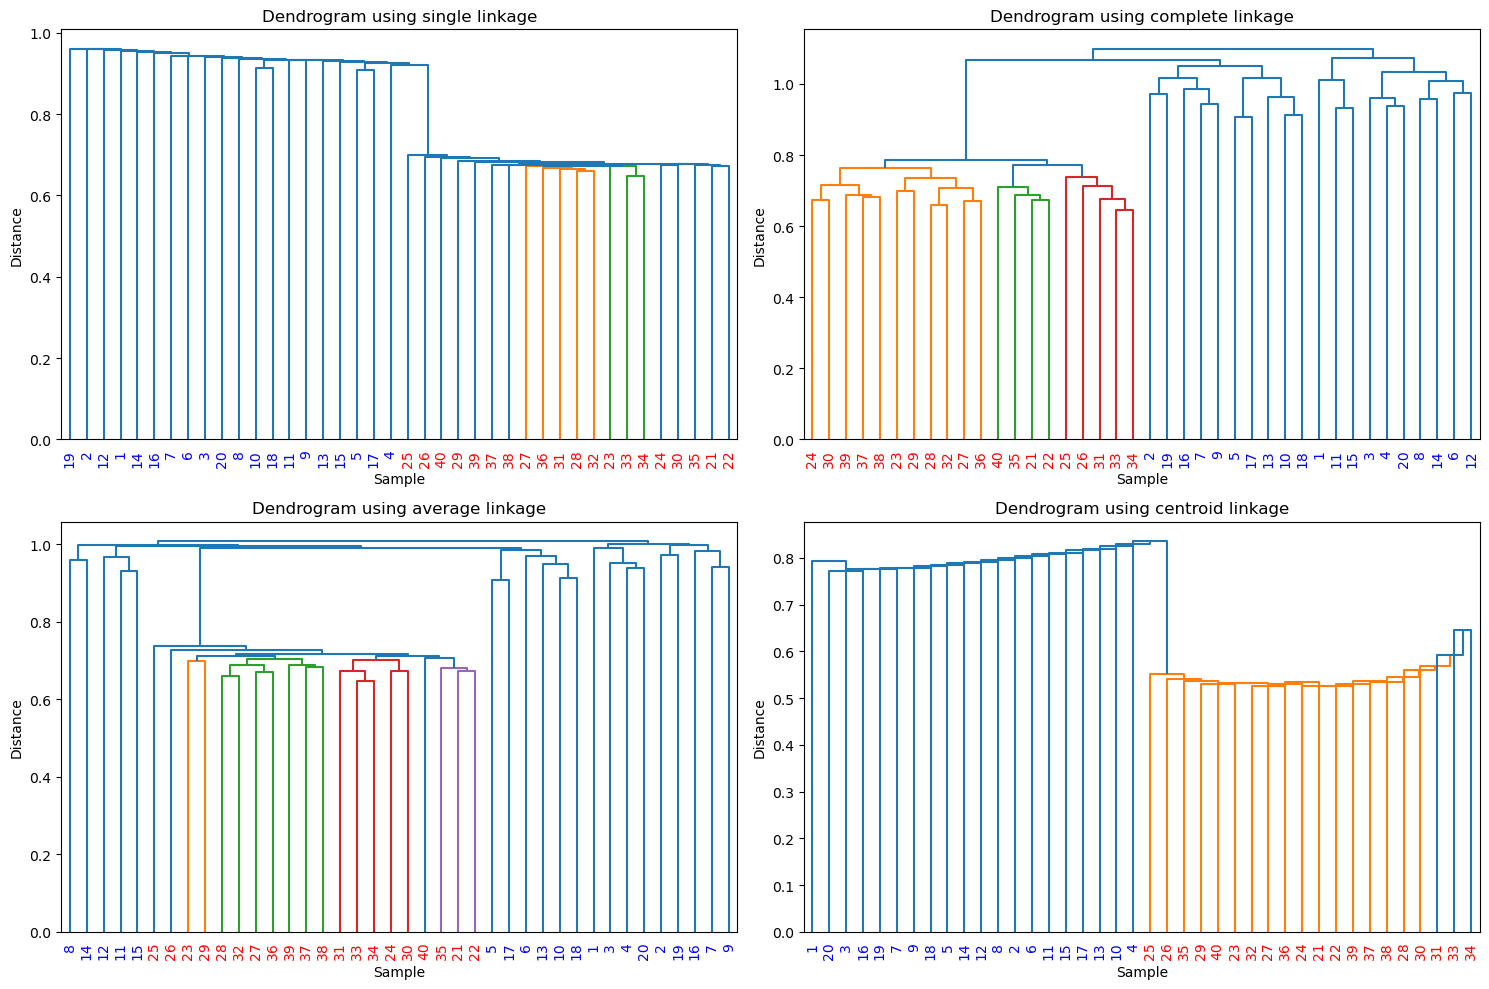

In [5]:
# Create a figure in which to plot all the dendograms:
fig = plt.figure(figsize=(15, 10))
linkage_methods = ["single", "complete", "average", "centroid"]
dendrograms = dict()

for i, linkage_method in enumerate(linkage_methods):
    plt.subplot(2, 2, i + 1)
    Z = linkage(distances, method=linkage_method)
    dendrograms[linkage_method] = Z
    dgram = dendrogram(Z, labels=range(1, 41), leaf_rotation=90, leaf_font_size=10)

    ax = plt.gca()
    ax.set_xlabel("Sample")
    ax.set_ylabel("Distance")
    ax.set_title(f"Dendrogram using {linkage_method} linkage")
    xlabels = ax.get_xticklabels()
    # Color the labels based on healthy (1-20) or diseased (21-40):
    for label in xlabels:
        sample_num = int(label.get_text())
        if sample_num <= 20:
            label.set_color("blue")  # healthy
        else:
            label.set_color("red")   # diseased

plt.tight_layout()
plt.show()

We can observe several things from these dendrograms:
* Both single and centroid linkage result in trailing clusters for which single
  observations are fused one-at-a-time (p. 530).
* Single and centroid linkage also display inversions, whereby some of the
  clusters are fused at a height below that of one of them. This is especially
  prominent in the centroid dendrogram.
* To my eye, none of the dendrograms furnish a clear separation between the
  true classes, but the one using complete (max) linkage gets close to doing so.

Let's verify the last conjecture by cutting each of these dendrograms in order
to obtain exactly $ 2 $ clusters and then checking their labels:

In [6]:
clusters = dict()

for linkage_method in linkage_methods:
    # Get the linkage matrix Z for this method:
    Z = dendrograms[linkage_method]  
    # Get the 2 clusters from this hierarchical clustering:
    cluster_assignments = fcluster(Z, 2, criterion="maxclust")
    # Extract the sample labels for each cluster:
    cluster_0_labels = [i + 1 for i, c in enumerate(cluster_assignments) if c == 1]
    cluster_1_labels = [i + 1 for i, c in enumerate(cluster_assignments) if c == 2]
    
    # Ensure consistent ordering: cluster containing sample 1 (healthy)
    # always comes first:
    if 1 in cluster_0_labels:
        clusters[linkage_method] = (cluster_0_labels, cluster_1_labels)
    else:
        clusters[linkage_method] = (cluster_1_labels, cluster_0_labels)

# Print the clusters for each linkage method:
for method, cluster_pair in clusters.items():
    print(f"Linkage Method: {method}")
    print(f"Healthy cluster (predicted): {cluster_pair[0]}")
    print(f"Diseased cluster (predicted): {cluster_pair[1]}")
    print()

Linkage Method: single
Healthy cluster (predicted): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Diseased cluster (predicted): [19]

Linkage Method: complete
Healthy cluster (predicted): [1, 3, 4, 6, 8, 11, 12, 14, 15, 20]
Diseased cluster (predicted): [2, 5, 7, 9, 10, 13, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Linkage Method: average
Healthy cluster (predicted): [1, 2, 3, 4, 7, 9, 16, 19, 20]
Diseased cluster (predicted): [5, 6, 8, 10, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Linkage Method: centroid
Healthy cluster (predicted): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]
Diseased cluster (predicted): []



Note that because of an inversion when joining the last two clusters, one of the
clusters for the dendrogram with centroid linkage is actually empty!

__13 (c):__ We begin by separating the gene expression values into the healthy
and diseased group. We will then perform a $ t $-test for each gene to determine
whether there is a significant difference in the mean expression values for this
gene between the two groups. Using the associated $ p $-values we can rank the
genes that appear to be most significant for predicting disease (or health).

In [7]:
healthy = gene_data.iloc[:, :20]  # healthy samples
diseased = gene_data.iloc[:, 20:]  # diseased samples

t_statistics = []
p_values = []
mean_diffs = []

# Perform t-test for each gene:
for gene in range(gene_data.shape[0]):
    # Extract gene expression values for both groups:
    healthy_gene_expressions = healthy.iloc[gene, :]
    diseased_gene_expressions = diseased.iloc[gene, :]
    # Perform t-test:
    t_stat, p_value = stats.ttest_ind(
        healthy_gene_expressions, diseased_gene_expressions, equal_var=False
    )
    t_statistics.append(t_stat)
    p_values.append(p_value)
    mean_diff = diseased_gene_expressions.mean() - healthy_gene_expressions.mean()
    mean_diffs.append(mean_diff)

For each $ j = 1, 2, \cdots, m $, we want to test the null hypothesis $ H_{0j} : $
_the mean expression values of gene $ j $ in the healthy and diseased populations are the same._
However, when performing multiple hypothesis testing, the probability of false
positives increases dramatically. For example, with $ m = 1,000 $ genes and a
significance threshold of $ 0.05 $, we expect 
$$
    1\,000 \times 0.05 = 50
$$
genes to appear significant _by chance alone_.

To try to address this problem, we can apply the Benjamini-Hochberg procedure to
control the false discovery rate (FDR). This is explained clearly in
chapter 13 of the book, specifically in section 13.4 (see Algorithm 13.2).
More precisely, now that we have already computed all $ p $-values $ p_1,
\cdots, p_m $, we:
1. Specify $ q $, the level at which to control the FDR. We will take $ q = 10\% $.
2. Sort (rank) all $ p $-values from smallest to largest into a sequence
   $$
    p_{(1)} \le p_{(2)} \le \cdots \le p_{(m)}\,.
   $$
3. Determine 
   $$
    L = \max\left\{j : p_{(j)} < \frac{q\,j}{m} \right\}\,.
   $$
4. Reject all null hypotheses $ H_{0j} $ for which $ p_j \le p_{(L)} $. In
   particular, notice that exactly $ L $ null hypotheses will be rejected (those
   corresponding to the $ L $ smallest $ p $-values).

This strategy can easily be implemented using `multipletests` from statsmodels:

In [20]:
# Adjust p-values for multiple testing using the Benjamini-Hochberg method:
reject, p_adjusted, _, _ = multipletests(p_values, method="fdr_bh")
gene_diff_results = pd.DataFrame({
    "Gene": range(1, gene_data.shape[0] + 1),
    "t_statistic": t_statistics,
    "p_value": p_values,
    "p_adjusted": p_adjusted,
    "mean_difference": mean_diffs,
    "abs_mean_diff": np.abs(mean_diffs)
})
print(reject.sum())  # number of rejected null hypotheses
gene_diff_results.sort_values("p_adjusted").head()

117


,Gene,t_statistic,p_value,p_adjusted,mean_difference,abs_mean_diff
501,502,-10.316705,1.530472e-12,1.530472e-09,2.544461,2.544461
588,589,-10.024607,6.511864e-12,3.255932e-09,2.343491,2.343491
599,600,-9.623413,1.003599e-11,3.345330e-09,2.747577,2.747577
589,590,-8.976247,1.123456e-10,2.808639e-08,2.205324,2.205324
564,565,-8.628749,1.765864e-10,3.531728e-08,2.470820,2.470820


We see that for $ 117 $ out of $ 1\,000 $ genes there appears to be a
significant difference in expression values between the healthy and diseased
populations, even when accounting for the effect of multiple testing.  Moreover,
the most significant adjusted $ p $-values are indeed quite small.  Still, from
the theory in chapter $ 13 $, we can expect that about $ 10\% $ of these are
false positives (i.e., the null hypothesis corresponding to that gene actually
holds, even though it was rejected).

Now let's visualize the expression values in the samples for the top $ 20 $
differentially expressed genes:

In [13]:
# Select top 20 genes for visualization:
gene_diff_results = gene_diff_results.sort_values("p_adjusted")
top_genes = gene_diff_results.head(20)["Gene"].values - 1
top_gene_data = gene_data.iloc[top_genes, :]

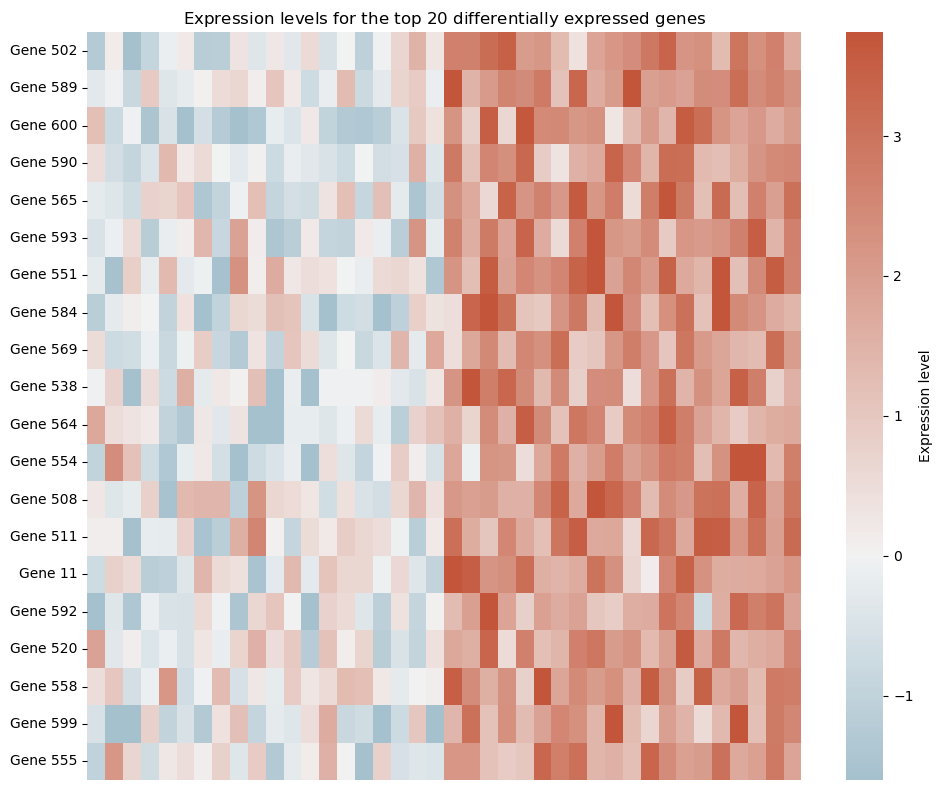

In [21]:
plt.figure(figsize=(10, 8))
sample_groups = ["Healthy"] * 20 + ["Diseased"] * 20
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(
    top_gene_data,
    cmap=cmap,
    center=0,
    robust=True,
    yticklabels=[f"Gene {g + 1}" for g in top_genes],
    xticklabels=False,
    cbar_kws={"label": "Expression level"}
)

plt.title("Expression levels for the top $ 20 $ differentially expressed genes")
plt.tight_layout()
plt.show()